In [2]:
import base64
import json
import os
import socket
import ssl
import threading
import time
import hashlib
from dataclasses import dataclass, asdict
from enum import Enum
from uuid import uuid4

from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.asymmetric import rsa, dh
from cryptography.hazmat.primitives.ciphers.aead import AESGCM
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.serialization import (
    load_pem_public_key,
)

# TLS Protocol

#### by Andon Gorchov (@thunderman913)

# Abstract

The Transport Layer Security (TLS) protocol is the cornerstone of secure communication on the internet. It is designed to provide privacy and data integrity between two communicating parties. This article emphasises on the cryptographic foundations that TLS uses and the practical implementations of the protocol. It begins with a detailed examination of cryptography fundamentals, which are crucial for understanding TLS, including both symmetric and asymmetric encryption techniques, key exchange mechanisms, cryptographic hash functions, and digital signatures. Then the protocol's architecture is analyzed, which includes the handshake process, session establishment, and the role of certificate authorities in trust establishment. Finally, a custom implementation of the protocol is created, explaining in depth how it all works.

## 1 Fundamentals of Cryptography

Cryptography is a technique of securing information and communications through the use of codes so that only those persons for whom the information is intended can understand and process it. Thus preventing unauthorized access to information. The prefix “crypt” means “hidden”, and the suffix “graphy” means “writing”. In cryptography, the techniques that are used to protect information are obtained from mathematical concepts and a set of rule-based calculations known as algorithms to convert messages in ways that make it hard to decode them. These algorithms are used for cryptographic key generation, digital signing, and verification to protect data privacy, web browsing on the internet and to protect confidential transactions such as credit card and debit card transactions. [1]

It has the following features:
- Confidentiality: The communicated information can only be accessed by the person for whom it is intended and nobody else should be able to access it
- Integrity: The received information must remain unaltered, accurate and exact
- Non-repudiation: After sending the message/information, the sender cannot revert it later on. That provides evidence of the communication and is crucial for situations, where accountability and legal disputes arise
- Authentication: This is a mechanism used to verify the identity of the user, system or entity
- Interoperability: It allows for secure communication between different systems and platforms
- Adaptability: Cryptography must continuously evolve and improve to stay ahead of any possible security threats, since one security breach could be fatal

### 1.1 Encryption Types

### 1.1.1 Symmetric Encryption

Symmetric-key algorithms are algorithms for cryptography that use the same cryptographic keys for both the encryption of plaintext and the decryption of ciphertext. The keys may be identical, or there may be a simple transformation to go between the two keys. The keys, in practice, represent a shared secret between two or more parties that can be used to maintain a private information link. [2]

<img src="./pictures/symmetric_encryption.png" alt="drawing" width="600"/>

- **Advanced Encryption Standard**

Advanced Encryption Standard (AES) is a symmetric block cipher algorithm. It puts data through multiple encryption rounds and splits a message into smaller 128 bits, which makes it more secure and reliable than older encryption methods. The most widespread algorithm was Data Encryption Standard (DES), but it was very insecure even in the 90s, which created the need for a more reliable encryption method. AES quickly became the most popular symmetric key cryptography algorithm. From 2003, even the US government has used it to protect classified information. What makes it so good is, that it works on byte data instead of bits, so it treats the 128-bit block size as 16 bytes during the encryption procedure and also the number of rounds of encryption to be carried out depends on the length of the data. For example 128-bit size has ten rounds, while the 256-bit has fourteen rounds. [16]

### 1.1.2 Asymmetric Encryption

Asymmetric encryption, also known as public-key encryption, is the field of cryptographic systems that use pairs of related keys. Each key pair consists of a public key and a corresponding private key. Key pairs are generated with cryptographic algorithms based on mathematical problems termed one-way functions. The security of public-key cryptography depends on keeping the private key secret; the public key can be openly distributed without compromising security. [3]

In a public-key encryption system, anyone with a public key can encrypt a message, yielding a ciphertext, but only those who know the corresponding private key can decrypt the ciphertext to obtain the original message. [3]

<img src="./pictures/asymmetric_encryption.png" alt="drawing" width="600"/>

### 1.2. Key Concepts in Cryptography

### 1.2.1 Key Exchange Mechanisms

  Key exchange mechanisms are essential protocols or algorithms, that enable two or more parties to securely establish shared keys over an insecure communication channel like the internet. They allow entries to share secret keys safely without the need to have physically exchanged anything beforehand.

  - **Diffie-Hellman**

  One of the most popular mechanisms is **Diffie-Hellman key exchange** as it is found in security protocols such as TLS, SSH and IPsec. To implement it, two end users (or client and server) mutually agree on positive whole numbers p and q, such that p is a prime number and q is a generator of p. The generator is a number that, when raised to a positive whole-number less than p, never produces the same result for any two such whole numbers. p may be large, but q is usually small. [4, 5]
  Once the users have agreed on p and q in private, they choose positive whole-number personal keys a and b. Both must be less than the prime number modulus p. Next, both parties compute public keys a* and b*, based on their personal keys:

$$a^* = (q ^ a)\mod p$$
$$b^* = (q ^ b)\mod p$$

  Then the users share the public keys a* and b* over the communication channel, that is insecure. From these public keys, a number x can be generated by either user on the basis of their own personal keys. They use each other's calculated numbers:

$$ x = (b^*)\mod p = (a^*)\mod p$$

  That way both parties manage to get the same number, but it is not shared in the insecure environment and neither are the private keys. Afterwards, the users can safely communicate using the encryption method of their choice with the decryption key x.

  Although it seems, that the algorithm can be easily reversed, knowing q, p and a*, it is not that simple. In large numbers and especially, when p is large enough (like 2048 bits), the brute force attack and other attack methods are not computationally feasible. That is because it should solve the Discrete Lograrith Problem, for which there is currently no efficient algorithm.

  An implementation of the Diffie-Hellman algorithm, can be found in the diffie-hellman.ipynb file.

  - **Rivest-Shamir-Adleman**

  Rivest-Shamir-Adleman (RSA) algorithm is an asymmetric cryptography algorithm. The idea of the algorithm is based on the fact that it is difficult to factorize a large integer, but easy to multiply large numbers. The public key consists of two numbers, where one is a multiplication of two large prime numbers and the private key is also derived from the same two prime numbers. That meeans if someone can factorize the large number, then the private key will be compromised. Because of that it is best if RSA keys are 2048 bit long, since 1024 bit keys might be broken in  the near future. [14]

  The first thing in the algorithm is to choose two prime numbers P and Q. Then we can calculate the first number of the public key:
  $$n = P * Q$$
  Next, a small exponent e must be chosen, which is an integer and is in the range 1 < e < Φ(n). It is usually 65537 in practice or if we are performing some tests, it is usually 3 or 17. e is the other part of the public key.
  
  After that we can calculate the private key using the formula:

  $$ d = (k * \phi(n) + 1)/e $$

  Then the encryption/decryption process can begin. We encrypt the data, by converting the letters to numbers 1-26, if using English letters only and using the formula:
  $$ encrypted \: data = (data^e) \mod n $$

  The decryption is performed using the formula:

  $$ decrypted \: data = ((encrypted \: data)^d) \mod n $$

An example code of RSA can be found in rsa.ipynb.

### 1.2.2 Cryptographic Hash Functions

A cryptographic hash function is a mathematical function used in cryptography. Typically, they take inputs of variable lengths to return outputs of a fixed length. Each input should have a unique output. There are many different algorithms, but we will look into two of them - MD5, which is old and currently flagged as insecure, and SHA-256, which is commonly used and marked as one of the best ones. [6]

- MD5 

MD5 takes the message as input of any length and changes it into a fixed-length message of 16 bytes. It was commonly used for authentication. Let's look into how the algorithm works. [7]

The first step of the algorithm is to add padding bits to the original message. The new length of the message should be 64 bits less than the exact multiple of 512, i.e., if we have 600 bits, we should add 360 bits, so that the length is 960, which is 1024 - 64. The added bits should be in the following order - the first is '1' and all the rest are zeros.

The next step is to add the length of the original message as 64-bit. For example, if the length is 24, we would add 00000000 seven times and then 00011000 (24 in binary). This is performed to increase the complexity of the function.

Then we initialize the 4 32-bit buffers, that are predefined in the MD5 algorithm. They are constant values, in order to ensure, that the starting point is always the same.

$$J = 0x67425301$$
$$K = 0xEDFCBA45$$
$$L = 0x98CBADFE$$
$$M = 0x13DCE476$$

The final step is to process each 512-bit block. A total of 64 operations are performed in 4 rounds, each containing 16 operations. A different function is applied each round. For each function 3 of the above mentioned buffers are used. We update the buffers on each operation. Here are the functions, that are performed:

\begin{align*}
    F(K, L, M) &= (K \land L) \lor (\neg K \land M) \\
    G(K, L, M) &= (K \land L) \lor (L \land \neg M) \\
    H(K, L, M) &= K \oplus L \oplus M \\
    I(K, L, M) &= L \oplus (K \lor \neg M)
\end{align*}

Finally after performing all the operations, we concatenate all the newly created buffers, which are 4 bytes each and we end up with a 16 byte hash.

After all, MD5 seems like a good hashing algorithm, hard to crack, but there are a couple of disadvantages to it:
- Sometimes MD5 generates the same hash function for different inputs, which makes it not collision resistant
- MD5 allows for fast computation, which that allows for easier and faster brute force attacks
- There are many rainbow tables with billions of hashes, which makes the most commonly hashed values easily accessible to attackers

In [3]:
inputstring = "Hello world"
output = hashlib.md5(inputstring.encode())

print("Hash of the input string:")
print(output.hexdigest())

Hash of the input string:
3e25960a79dbc69b674cd4ec67a72c62


- SHA-256

The SHA-256 algorithm plays a pivotal role in the modern digital security and data integrity. It produces a fixed-sized output of 32 bytes (256 bits). It's nature is very similar to the MD5 algorithm, but uses more complex functions, more buffers and produces bigger result. That makes it's computation a bit slow, but it's security a lot higher. [8]

During the algorithms, first the initial hash value (buffers) must be initialized. They have constant values:

\begin{align*}
H_0 &= \texttt{0x6a09e667} \\
H_1 &= \texttt{0xbb67ae85} \\
H_2 &= \texttt{0x3c6ef372} \\
H_3 &= \texttt{0xa54ff53a} \\
H_4 &= \texttt{0x510e527f} \\
H_5 &= \texttt{0x9b05688c} \\
H_6 &= \texttt{0x1f83d9ab} \\
H_7 &= \texttt{0x5be0cd19}
\end{align*}

Then we prepare the initial input by appending '1' bit and then appending '0' bits until the message is 64 bits less than an exact multiple of 512. Finally similar to the MD5, the length of the original message gets appended to the end as 64 bit integer.

Afterwards similar to MD5, we divide the message into 512-bit blocks and each of them is further divided into sixteen 32-bit words. Then comes the algorithm of SHA-256, which is a lot more complex than the one of MD5. More information on the complex algorithm can be found in [9].

After the algorithm is finished, we concatenate all the buffers and end up with the final hashed product.


In [4]:
inputstring = "Hello world"
output = hashlib.sha256(inputstring.encode())

print("Hash of the input string:")
print(output.hexdigest())

Hash of the input string:
64ec88ca00b268e5ba1a35678a1b5316d212f4f366b2477232534a8aeca37f3c


Let's do some comparisons between MD5 and SHA256 computation times.
Using the library openssl we can run some speedtests on how much it takes to compute hashes. The command is

$$ \text{\texttt{openssl\ speed\ [algorithm]}} $$


The time taken to compute an input of a certain length for the different algorithms can be seen below. We can see for ourselves. On the y axis is the speed measured in Mbits. The output from the speed command is in Kbits, but since everywhere on the internet Mb's are used, that is why we convert them to a more broadly used measuring unit. On the x axis can be seen the length of the input in bytes. It can be observed, that SHA256 proportionally takes more time to calculate, compared to MD5, when having lenghtier inputs. That is because SHA256 is more complex and has a higher number of computational rounds, which requires more processing time for larger inputs.

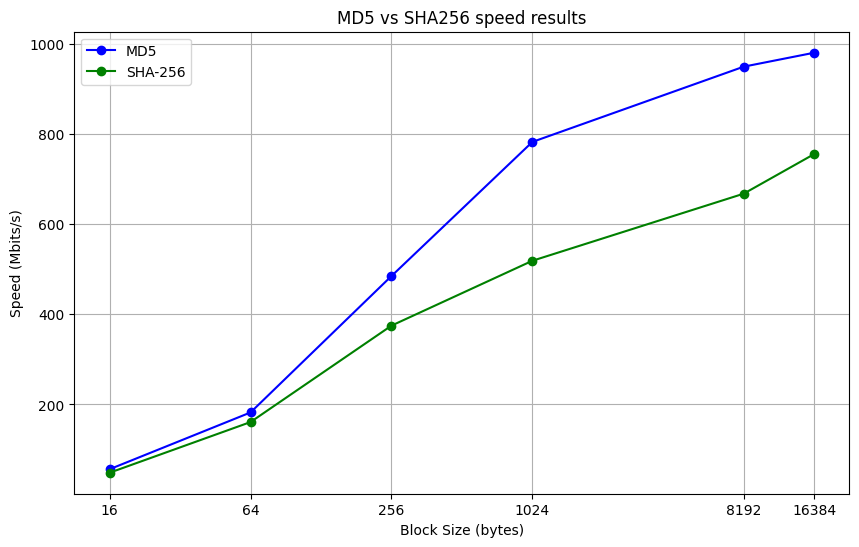

In [10]:
# Data from openssl speed test
data_sizes = [16, 64, 256, 1024, 8192, 16384]  # Sizes in bytes
md5_speeds = [57637.75, 186542.30, 496239.12, 800811.69, 971717.40, 1003377.58]  # Speeds in kbits per second for md5
sha256_speeds = [49686.86, 164736.43, 383642.47, 530966.57, 683317.10, 773242.47]  # Speeds in kbits per second for sha256

# Convert speeds to Mbits per second for better readability
md5_speeds_mbps = [x / 1024 for x in md5_speeds]
sha256_speeds_mbps = [x / 1024 for x in sha256_speeds]

plt.figure(figsize=(10, 6))
plt.plot(data_sizes, md5_speeds_mbps, marker='o', linestyle='-', color='blue', label='MD5')
plt.plot(data_sizes, sha256_speeds_mbps, marker='o', linestyle='-', color='green', label='SHA-256')

plt.title('MD5 vs SHA256 speed results')
plt.xlabel('Block Size (bytes)')
plt.ylabel('Speed (Mbits/s)')
plt.xscale('log', base=2)
plt.xticks(data_sizes, [str(size) for size in data_sizes])
plt.grid(True)
plt.legend()

plt.show()


### 1.2.3 Digital Signatures

Digital signatures are the public-key primitive of message authentication. In the real world, we use handwritten signatures and similarly, a digital signature is a technique, that binds an entity to digital data. The binding can be independently verified by the receiver as well as any third party. Digital signatures represent a cryptographic value, that is calculated from the data and a secret key known only to the signer. [10]

They most commonly involve using public-key cryptography. The signer has two keys at his disposal - private and public and only he knows what his private key is and shouldn't share it with anyone. Whenever he sends the data to another person, then he can verify him by using his public key.

<img src="./pictures/digital_signature_process.png" alt="drawing" width="600"/>

The signer prepares the data, that needs to be sent securely and uses a hashing function to create a hash value from the data. He encrypts the hash value with the private key using a signature algorithm. Then he sends the data and the public key signature.

The verifier receives the data and the digital signature from the signer. He uses the same hashing function to generate a hash value from the received data. He uses the public key and the verification algorithm to verify the digital signature. It involves decrypting the signature with the public key to obtain the original hash value. Then he checks if the hash he received is the same as the decrypted one and if they match, then the signature is genuine.

### 1.2.4 Message Authentication Codes

  Message Authentication Code (MAC) is a short piece of information, that can be added to a message to provide authenticity and integrity. The algorithm uses a symmetric key cryptographic technique to provide message authentication. The sender and the receiver share the same symmetric key. [15]

  <img src="./pictures/message_authentication_codes.png" alt="drawing" width="600"/>

  1. The sender uses some publicly known MAC algorithm, inputs the message and the secret key K and produces a MAC value.
  2. Similar to hash, MAC function also compresses an arbitrary long input into a fixed length output. The major difference between hash and MAC is that MAC uses a secret key during the compression.
  3. The sender forwards the message along with the MAC. Here, we assume that the message is sent in the clear, as we are concerned with providing message origin authentication, not confidentiality. If confidentiality is required then the message needs encryption.
  4. On receipt of the message and the MAC, the receiver feeds the received message and the shared secret key K into the MAC algorithm and re-computes the MAC value.
  5. The receiver now checks the equality of the freshly computed MAC with the MAC received from the sender. If they match, then the receiver accepts the message and assures himself that the message has been sent by the intended sender.
  6. If the computed MAC does not match the MAC sent by the sender, the receiver cannot determine whether it is the message that has been altered or it is the origin that has been falsified. As a bottom-line, a receiver safely assumes that the message is not the genuine.

  MACs are similar to digital signatures, but they also have some differences:
  - MACs use symmetric key cryptography, while digital signatures use asymmetric
  - MACs don't provide non-repudiation
  - Any user who can verify a MAC can also generate a MAC, which might be a security concern

### 1.2.5 Cipher Suite

A cipher suite is a set of cryptographic algorithms, which are widely used in the TLS protocol to create keys and encrypt information. It specifies different algorithms for key exchange, bulk encryption and message authentication. [18]  Usually the TLS protocol supports multiple cipher suites and based on what the clients support, it can handle different scenarios, but the cipher suite, that will be looked into and implemented in the current project will be **TLS_DH_RSA_WITH_AES_256_GCM_SHA256**. It contains several different, but important parts. **TLS** stands for the protocol that will be used, it can also be SSL for example. **DH** (Diffie-Hellman) is the key exchange algorithm, that will be used. It could be other algorithms such as RSA, ECDHE and many more. **RSA** refers to the digital signature and authentication, that will be used. Instead of it, ECDSA or DSS could also be seen in this position. **AES_256_GCM** is the encryption algorithm. It represents a subtype of AES, that uses XOR on each block of plaintext. This could be another algorithm like DES_GCM, 3DES_EDE_GCM or even AES_256_GCM - AES with different operations. Finally **SHA256** represents the hashing algorithm for the message authentication. It could be other algorithms such as MD5, SHA1 or SHA384.

# 2. TLS Protocol

In order to establish secure communication between two sides in an unsecure environment like the internet, we need to use all of the above mentioned principles and security measures.


Cryptographic protocols are sets of rules, that dictate how algorithms and cryptographic keys should be used to achieve secure communications. These protocols ensure the data is encrypted, transmitted securely and decrypted only by the intended recipient.

## 2.1 Overview of the TLS Protocol

There are many different protocols, that are used for such purposes, but the most commonly seen is TLS (Transport Layer Security). It is a direct successor to SSL (Secure Sockets Layer), which is no longer used. TLS is widely used in the internet, since almost all of the websited, that use HTTPS rely on it. It encrypts the data, that is transmitted and no one can intercept it. It will only be able to be read from the intented recipient. TLS Uses all of the above mentioned key concepts - symmetric and asymmetric encryption, key exchange mechanisms (like Diffie-Hellman), cryptographic hash functions (like SHA-256) and digital signatures.

### 2.1.1 Introduction to TLS

TLS is a critical protocol for ensuring secure communication over the internet. It is developed as the successor to SSL and enhances the security of the data transmitted between web servers and clients. It is designed to prevent any kind of forgery in client-server communication. It is used in every single part of the internet - instant messaging, email, web browsing and everything, that uses the HTTPS protocol.

The protocol operates between the network and application layer in the OSI model, enabling it to manage security independently of application protocols. This results in easy integration of the protocol by the developers without any changes to the application logic.

TLS is very significant in the modern digital landscape. It not only provides tools for secure communication, but also mechanisms for authenticating both the sender and the receiver. This ensures, that the data doesn't get intercepted or altered during the transmission and the parties in the communication are the ones, they claim to be.

### 2.1.2 Key Features of TLS

TLS is essential for safeguarding data transmitted over the internet, ensuring secure communication between web servers and clients. In order to guarantee the safety, it must implement several key features.

- Encryption

TLS can use both symmetric and asymmetric encryption to provide security for data in transit. Symmetric encryption uses a single key to encrypt and decrypt information, enabling fast and efficient data handling. One of the most popular such algorithms is AES (Advanced Encryption Standard). Asymmetric encryption, on the other hand, uses a pair of keys - public and private, adding an additional layer of security. A popular such algorithm is RSA (Rivest-Shamir-Adleman).

- Integrity

One key feature of a protocol like TLS is having mechanisms to verify, that the data sent is the same as the data received. It is managed through mechanisms like MAC (Message Authentication Codes) and cryptographic hash functions. They prevent any alteration of the data during transit, whether by accident or with malicious intent, thus ensuring the information remains unchanged from the sender to the receiver.

- Authentication

Authentication is a key feature of TLS, because it provides means to verify the integrity of the parties involved in the communication. This is achieved through digital certificates, which are issued and verified by trusted Certificate Authorities. That way, TLS ensures, that the users are actually communicating with the servers they believe are connected to, which prevents any impersonation attempts and fraudulent activities.

- Non-Repudiation

Non-repudiation is a security principle, that ensures a party in the transaction cannot deny the authenticity of their signature on a message, that they send. It is particularly important in legal and financial environments, where proof of actions may be required. It is again achieved by using digital signatures.

### 2.1.3 TLS Protocol Structure and Layers

TLS is composed of several protocols, each serving a distinct purpose in  secure communication between the parties.

- Record Protocol

The Record Protocol layers on top of a reliable connection-oriented transport, such as TCP. It provides data confidentiality using symmetric key cryptography and data integrity using a keyed Message Authentication Code (MAC). The keys are generated uniquely for each session based on the security parameters agreed upon during the TLS handshake. The Record Protocol is also used for encapsulating various upper layer protocols – most notably the TLS Handshake Protocol – in which case it can be used without encryption or message authentication. [11] It performs the following operations in order:

1. Read messages for transmit.
1. Fragment messages into manageable chunks of data.
1. Compress the data, if compression is required and enabled.
1. Calculate a MAC.
1. Encrypt the data.
1. Transmit the resulting data to the peer.

On the receiver side, the same operations are performed, but in reverse order:

1. Read received data from the peer.
1. Decrypt the data.
1. Verify the MAC.
1. Decompress the data, if compression is required and enabled.
1. Re-assemble the message fragments.
1. Deliver the message to upper protocol layers.

- Handshake Protocol

The Handshake Protocol is the most complex part of TLS. It is responsible for the initial negotiation between the client and server, when a connection is first established. It ensures, that both parties have agreed on the security parameters and have exchanged the necessary keys securely, in order to begin their reliable connection. This protocol will be looked at in depth in Section 2.1.4.

- Alert Protocol

The Alert Protocol is there to allow signals to be sent between peers. These signals are mostly used to inform the peer about the cause of a protocol failure. Some of these signals are used internally by the protocol and the application protocol does not have to cope with them, and others refer to the application protocol solely. An alert signal includes a level indication which may be either fatal or warning. Fatal alerts always terminate the current connection, and prevent future re-negotiations using the current session ID. Under the newest version of TLS - 1.3, all alerts are fatal and terminate the connection. [12]

Some of the critical alerts are:
- `unexpected_message`: An inappropriate message was received.
- `bad_record_mac`: An incorrect MAC was received.
- `decompression_failure`: The decompression function received improper input.
- `handshake_failure`: Sender was unable to negotiate an acceptable set of security parameters given the options available.
- `illegal_parameter`: A field in a handshake message was out of range or inconsistent with other fields.
- `close_notify`: Notifies the recipient that the sender will not send any more messages on this connection. Each party is required to send a close_notify alert before closing the write side of a connection.
- `no_certificate`: May be sent in response to a certificate request if no appropriate certificate is available.
- `bad_certificate`: A received certificate was corrupt (e.g., contained a signature that did not verify).



- Change Cipher Spec Protocol

The Change Cipher Spec Protocol is a critical component of the TLS suite, as it is designed to signal transitions in security specification during a TLS session. When used, it indicates a change in the encryption and MAC settings, that are used in the secure session. This change usually occurs after the handshake is done, but before the finalization of the security settings. After sending/receiving the Cipher Spec Message, both the client and the server must update their encryption parameters to begin encrypting and decrypting the messages using the negotiated settings. [19]

It marks the final part of the negotiation phase of a TLS session. Once all the information for the session has been exchanged and the handshake has been performed, then both the server and the client send the Change Cipher Spec message. Afterwards both parties send a 'Finished' message, which is the first encrypted data, sent using the new security settings. It serves to confirm, that the whole process has been successful and no tampering has occured.

### 2.1.4 The TLS Handshake Process

  We will look into TLS 1.2 handshake process. In TLS 1.3 the process is a bit simplified, with only one round trip between the client and the server. That is because TLS 1.2 uses a smaller number of cipher suites and the first roundtrip can be skipped.

  <img src="./pictures/tls_handshake.png" alt="drawing" width="600"/>

  In order to begin a TLS communication, the client and server must go through a handshake process. It includes the following steps in the given order:

- **Client Hello** - The client sends the server information including the highest version of TLS that it supports and a list of the cipher suites that it supports. The cipher suite information includes cryptographic algorithms and key sizes.
- **Server Hello** - The server chooses the highest version of TLS and the best cipher suite that both the client and server support and sends this information to the client.
- **(Optional) Certificate** - The server sends the client a certificate or a certificate chain, typically beginning with the server's public key certificate and ending with the certificate authority's root certificate. This message is used whenever server authentication is required.
- **(Optional) Server Key Exchange** - The server sends the client a server key exchange message if the public key information from the Certificate is not sufficient for key exchange. For example, in cipher suites based on Diffie-Hellman (DH), this message contains the server's DH public key.
- **Server Hello Done** - The server tells the client that it is finished with its initial negotiation messages.
- **Client Key Exchange** - The client generates information used to create a key for symmetric encryption. For RSA, the client then encrypts this key information with the server's public key and sends it to the server. For cipher suites based on DH, this message contains the client's DH public key.
- **(Optional) Certificate Verify** - This message is sent by the client when the client presents a certificate as previously explained. Its purpose is to allow the server to complete the process of authenticating the client. When this message is used, the client sends information that it digitally signs using a cryptographic hash function. When the server decrypts this information with the client's public key, the server is able to authenticate the client.
- **Change Cipher Spec** - The client sends a message telling the server to change to encrypted mode.
- **Finished** - The client tells the server that it is ready for secure data communication to begin.
- **Change Cipher Spec** - The server sends a message telling the client to change to encrypted mode.
- **Finished** - The server tells the client that it is ready for secure data communication to begin. This is the end of the TLS handshake.

After the handshake is performed, the client and server can now transfer encrypted data between one another. At the end of the connection each side sends a close_notify alert to inform the peer, that the connection is closed. [13]

In TLS 1.3 only one roundtrip occurs. The client sends the ClientHello and key in the same call. Then the server does the key share and all the optional steps, as well as returning Finished, all in the same call to the client. Afterwards the client begins sending data to the server and with the first message it sends the Finished as well. That eliminates a total of two roundtrips between the client and the server, resulting in better performance. [21] The difference can be seen in the image below.

  <img src="./pictures/tls1_3_performance.png" alt="drawing" width="600"/>


## 2.2 Certificate Authorities and Trust Models

  A certificate authority (CA) is a trusted organization that issues digital certificates for websites and other entities. CAs validate a website domain and, depending on the type of certificate, the ownership of the website, and then issue TLS/SSL certificates that are trusted by web browsers like Chrome, Safari and Firefox. Thus, CAs help keep the internet a safer place by verifying websites and other entities to enable more trust in online communications and transactions.

  A certificate authority is a company or organization that acts to validate the identities of entities (such as websites, email addresses, companies, or individual persons) and bind them to cryptographic keys through the issuance of electronic documents known as digital certificates.

  A digital certificate provides:

  - Authentication, by serving as a credential to validate the identity of the entity that it is issued to.
  - Encryption, for secure communication over insecure networks such as the internet.
  - Integrity of documents signed with the certificate so that they cannot be altered by a third party in transit.

  These certificates allow secure, encrypted communication between two parties through public key cryptography. The CA verifies the certificate applicant’s identity and issues a certificate containing their public key. The CA will then digitally sign the issued certificate with their own private key which establishes trust in the certificate’s validity.

  When requesting a certificate from a CA, the applicant first generates a public and private key pair. The private key should remain under the applicant’s sole control and ownership. The applicant then sends a certificate signing request (CSR) containing their public key and other identifying details to the CA through an online form.

  Next, the CA will take steps to validate the applicant’s identity and the right to claim credentials such as domain names for server certificates or email addresses for email certificates in the CSR.   If validation is successful, the CA issues the certificate containing the details and public key from the CSR. The CA digitally signs the issued certificate with their own private key to confirm they verified the identity. [20]


# 3. Implementation and comparison

This section explores two distinct approaches to implementing TLS in a python project environment. The first one is utilizing established cryptographic libraries like OpenSSL. This is widely used in production grade servers as it is much simpler and reliable. The other one is developing custom TLS protocol components from scratch. We will look into the second one, mostly from a learning perspective and to show exactly what happens during a TLS handshake. In production environments it is highly advised, that the server use well known and established libraries such as OpenSSL. 

## 3.1 Using Existing Code Libraries

There are many different libraries, that can be used to implement TLS communication:

- OpenSSL is a full-featured open-source toolkit for implementing TLS and SSL. It is widely supported by a large community, which makes it a reliable choice for secure communications.
- BoringSSL is a fork of OpenSSL, that is developed by Google. It is designed to be much simpler and more secure by removing unnecessary features and having general improvements and refactorings. It is used by Google in their own projects such as Chrome and Android.
- Other libraries - there are many different libraries, that implement TLS, e.g. GnuTLS, WolfSSL, mbedTLS and so on. They offer various features and levels of support for the protocol.

There are many benefits to using an established TLS library instead of developing your own security protocol. They are much more reliable, since they are widely used in the industry. That makes the likelihood of security vulnerabilities and bugs very low. Most of them are also open source such as OpenSSL and BoringSSL and active communities with thousands of members contribute to their development, maintenance and figuring out potential security risks. Also, since these libraries are so widely used, they are always compliant with security standards and protocols, which again ensures, that there are no security threats.

Now lets see a simple OpenSSL implementation of the TLS protocol in python. The example will focus on creating a server and a client, which will connect with each other using the TLS protocol. They will send a couple of messages and that's about it.

Before the development begins, the signed certificates have to be created. We create two certificates with the following command:

```bash
openssl req -x509 -nodes -days 365 -newkey rsa:2048 -keyout {name}.key -out {name}.crt -config san.cnf


The command seems long, but it contains the following pieces:

- openssl req - tells OpenSSL to create a certificate signing request (CRS) and certificate
- x509 - specifies, that a self-signed certificate will also be created, rathen than just a CSR
- nodes - tells opensSSL not to encrypt the private key and store it in plaintext
- days 365 - sets the validity of the certificate to 365 days
- newkey rsa:2048 - generates a private RSA key of 2048 bits
- keyout name.key - specifies the filename to save the private key to
- out name.crt - specifiest the filename to save the certificate to
- config san.cnf - specifies the configuration settings to set up the certificate

After creating the certificates we can now prepare the functions to create the server and the client.

In [5]:
def create_server(max_connections=5):
    context = ssl.SSLContext(ssl.PROTOCOL_TLS_SERVER)
    context.load_cert_chain(certfile='tls_certificates/server.crt', keyfile='tls_certificates/server.key')
    context.load_verify_locations('tls_certificates/client.crt')
    context.verify_mode = ssl.CERT_REQUIRED

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM, 0) as sock:
        sock.bind(('127.0.0.1', 4433))
        sock.listen(5)
        with context.wrap_socket(sock, server_side=True) as ssock:
            connection_count = 0
            while connection_count < max_connections:
                conn, addr = ssock.accept()
                with conn:
                    print(f"Server got connected by {addr}")
                    while True:
                        data = conn.recv(1024)
                        if not data:
                            break
                        decodedData = data.decode('utf-8')
                        print(f"Server Received: {decodedData}")
                        message = decodedData.strip().lower()
                        print(f"Server Sent: {message}")
                        conn.sendall(data)
                        if message == "shutdown":
                            print("Shutdown command received. Shutting down server.")
                            return
                connection_count += 1
            print("Max connections reached, server shutting down.")


First the function **create_server** is defined. It's goal is to create a TLS server, that will be awaiting the connections and requests.

It begins with configuring the context. It is essential for managing the security settings, which include loading the server certificate and the required verifications for the client certificate, that will be expected in the calls..

Then the socket gets set up. It is hardcoded to get bound to the localhost (127.0.0.1) address and port 4433. The server will listen for requests on this address and it is given a maximum number of five connections to hold on, at a time.

Afterwards, the server enters a loop to accept and handle incoming connections. The server always checks whether the maximum connections has been reached and if so - it doesn't accept any new ones. All the incoming connections are wrapped in the SSL context (ssock). It ensures, that the data transferred is always secure.

The server then enters a loop, where it receives data from the client until no more data is sent. The data is decoded, printed and returned back to the client. In a non-demonstration case, the server will most likely perform some complicated business logic, instead of just returning a lowered version of the input.

When the server receives a 'shutdown' command, it exits the loop and starts the shutdown process. For the demonstration, when the server receives this command the whole server stops, so it doesn't run indefinately.

Afterwards, the create_client function is defined. It sets up a secure client, that communicates over TLS with the server and performs a series of message exchanges.

In [6]:
def create_client():
    context = ssl.create_default_context(ssl.Purpose.SERVER_AUTH)
    context.load_cert_chain('tls_certificates/client.crt', 'tls_certificates/client.key')
    context.check_hostname = False
    context.verify_mode = ssl.CERT_REQUIRED
    context.load_verify_locations('tls_certificates/server.crt')

    with socket.create_connection(('127.0.0.1', 4433)) as sock:
        with context.wrap_socket(sock, server_hostname='127.0.0.1') as ssock:
            messages = [b"Hello, TLS!", b"Another encrypted message", b"shutdown"]
            for msg in messages:
                ssock.sendall(msg)
                print(f"Client Sent: {msg.decode('utf-8')}")
                response = ssock.recv(1024).decode('utf-8')
                print(f"Client Received: {response}")
                if msg == b"shutdown":
                    print("Client sent shutdown command. Exiting.")
                    break


As with the server, the first thing the client does is to set up the context. It loads its own certificate and verifies the server's certificate. The hostname check is disabled, due to the fact that an IP address is used for the connection, rather than a domain name.

Afterwards, the client establishes a secure connection with the hard-coded address of the server - 127.0.0.1:4433. Then the message sending process begins. It initializes an array of all the messages as bytes. It iterates through all of them, sends them to the server and decodes the response. Every time it prints the corresponding action, so we can track it.

Then the execution of the above functions is performed:

In [7]:
server_thread = threading.Thread(target=create_server)
server_thread.start()

# Wait for the server to be ready
time.sleep(1)

create_client()

server_thread.join()

Client Sent: Hello, TLS!
Server got connected by ('127.0.0.1', 64045)
Server Received: Hello, TLS!
Server Sent: hello, tls!
Client Received: Hello, TLS!
Client Sent: Another encrypted message
Server Received: Another encrypted message
Server Sent: another encrypted message
Client Received: Another encrypted message
Client Sent: shutdown
Server Received: shutdown
Server Sent: shutdown
Shutdown command received. Shutting down server.
Client Received: shutdown
Client sent shutdown command. Exiting.


The client and the server must run concurrently and that is the reason why threads are used. It is much easier for developing purposes to have them in the same script and session.

So firstly, the server is started separately and then the program waits for one second, which is enough time for the server to get ready. Then the client is executed on the main thread. There is no reason to run it on a separate thread, since the server is already running on one and the client is executed just once. It performs all of the calls to the server and after that the program waits for the server thread to execute. Afterwards, it finishes the whole script.

The sequence of print statements shows the communication between a client and server using the TLS protocol. The client sends three messages, the final one being the shutdown one. The server returns each message back to the client and returns the received messages, but lowercased. All of the messages are printed, so the communication can easily be tracked. The last command the server receives is the "shutdown", which leads to stopping down the server. This demonstrates a typical flow of secure message exchange and command processing in a client-server architecture.

## 3.2 Implementing Own TLS Components

Implementing own TLS components is a complex process with a lot of challenges to consider. The primary obstacle is ensuring the security, since minor errors in the implementation could lead to significant vulnerabilities. Another potential difficulty is adhering to standards, since the TLS protocol is governed by strict standards, that ensure interoperability between different systems. Performance of the protocol is also crucial, since cryptographic operations are resource-intensive and a handshake process is used upon every request.

Based on the above mentioned difficulties, it is highly not recommended to use custom implementations in any production environment, since there could be some very minor flaws, that could cause potential breaches. The implementation of this project is only exemplary, in order to show the whole process and how the protocol works. It is not fully based on the standards and for sure, doesn't have the perfect security, which it aims to achieve.

As we mentioned above, we will look into a TLS implementation with cipher suite TLS_DH_RSA_WITH_AES_256_GCM_SHA256. For that reason, the first thing we need is some Diffie-Hellman implementation:

In [8]:
parameters = dh.generate_parameters(generator=2, key_size=2048, backend=default_backend())

def create_dh_keys():
    """
    Generate DH parameters and keys for two entities using the same parameters.

    :return: A tuple containing both private key and public key.
    """

    private_key = parameters.generate_private_key()

    # Extract public keys from the private keys
    public_key = private_key.public_key()

    return private_key, public_key

def derive_key(private_key, public_key, algorithm=hashes.SHA256(), length=32, salt=None, info=b'handshake data'):
    """
    Derives a key from a shared secret using the HKDF algorithm.

    Args:
        private_key: The private key.
        public_key: The public key of the other side.
        algorithm: The hash algorithm to use with HKDF.
        length: The length of the derived key in bytes.
        salt: Optional salt used in the derivation (None means no salt).
        info: Optional context and application specific information.

    Returns:
        The derived key.
    """

    shared_secret = private_key.exchange(public_key)
    return HKDF(
        algorithm=algorithm,
        length=length,
        salt=salt,
        info=info,
        backend=default_backend()
    ).derive(shared_secret)

def public_key_to_pem(public_key):
    """
    Serializes a public key to a PEM format string.

    Args:
        public_key (PublicKey): The public key object to serialize.

    Returns:
        str: The public key in PEM format as a string.
    """
    pem = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )
    return pem.decode('utf-8')

We create two methods, which help us later on with the implementation. The "create_dh_keys" generates the public and private keys, based on the configuration and returns it. The "derive_key" method calculates the shared key by passing it the private key of one side and the public key of the other side. We use SHA256 algorithm, since it is mentioned in the cipher suite. Also we create a helper method called "public_key_to_pem", which converts the DH public key to the PEM format, so it can be passed easily.

Next we need some RSA implementation, that will help us with the protocol. We aren't going to use Certificate Authority for the example, so we will only generate a RSA key and return it to the client.

In [9]:
def generate_and_save_rsa_keys(private_key_file='tls_certificates/rsa_keys/private_key.pem', public_key_file='tls_certificates/rsa_keys/public_key.pem'):
    """
    Generates an RSA private and public key pair and saves them to specified files in PEM format.

    Args:
        private_key_file (str): Path where the private key will be saved. Defaults to 'tls_certificates/rsa_keys/private_key.pem'.
        public_key_file (str): Path where the public key will be saved. Defaults to 'tls_certificates/rsa_keys/public_key.pem'.

    The function generates a new RSA private key with a key size of 2048 bits and a public exponent of 65537,
    which is common for RSA keys. It then saves the private key unencrypted and the public key in separate files,
    both in PEM format. The private key is stored without encryption, which may not be suitable for production environments.
    """

    # Generate RSA private and public keys
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048,
        backend=default_backend()
    )
    public_key = private_key.public_key()

    # Save the private key to a file without encryption
    with open(private_key_file, "wb") as key_file:
        key_file.write(
            private_key.private_bytes(
                encoding=serialization.Encoding.PEM,
                format=serialization.PrivateFormat.TraditionalOpenSSL,
                encryption_algorithm=serialization.NoEncryption()
            )
        )

    # Save the public key to a file
    with open(public_key_file, "wb") as key_file:
        key_file.write(
            public_key.public_bytes(
                encoding=serialization.Encoding.PEM,
                format=serialization.PublicFormat.SubjectPublicKeyInfo
            )
        )

def load_rsa_private_key(private_key_file='tls_certificates/rsa_keys/private_key.pem'):
    """
    Loads an RSA private key from a specified PEM file.

    Args:
        private_key_file (str): Path to the file from which the private key is to be loaded. Defaults to 'tls_certificates/rsa_keys/private_key.pem'.

    This function reads a PEM-formatted private key from a file. It assumes the key is stored unencrypted,
    reflecting how the key was originally saved. This method is generally used for cryptographic operations
    that require a private key, such as decrypting data or signing.

    Returns:
        PrivateKey: The RSA private key loaded from the file.
    """
    # Load the private key from a file
    with open(private_key_file, "rb") as key_file:
        private_key = serialization.load_pem_private_key(
            key_file.read(),
            password=None,
            backend=default_backend()
        )

    return private_key

# Call the function to generate and save the keys
generate_and_save_rsa_keys()

The "generate_and_save_rsa_keys" method is used to generate the rsa keys of the server. Using the "load_rsa_private_key" method, the server can read the the generated keys and return the public key to the client.

Next up, we need some sort of implementation for the cipher suites, so they aren't passed as just normal strings. That's why an enum class is created. In the future if we want to support more options, we can just add it in the cipher suites enum and implement the corresponding algorithms. Although some adjustments in the code might be required.

In [10]:
class CipherSuites(Enum):
    """
    An enumeration of supported cipher suite identifiers for cryptographic communications.
    """
    TLS_DH_RSA_WITH_AES_256_GCM_SHA256 = 0x0000
    TLS_DH_RSA_WITH_AES_256_CBC_SHA256 = 0x0001

def select_preferred_ciphersuite(client_supported, server_supported):
    """
    Selects a preferred cipher suite from the server's supported list based on the client's supported cipher suites.

    Args:
        client_supported (list of int): A list of cipher suite values supported by the client.
        server_supported (list of CipherSuites): A list of CipherSuites enum members representing the server's supported cipher suites.

    Returns:
        CipherSuites or None: The first mutually supported cipher suite if found, otherwise None.
    """
    for i in server_supported:
        assert isinstance(i, CipherSuites)
        if i.value in client_supported:
            return i
        
    return None

The cipher suites contain a method, named "select_preferred_ciphersuite", which searches for a simillar cipher suite between the client and server and selects it.

Next up, we need to create some classes for the handshake process and the communication afterwards. That's why ServerHello, ClientHello and Message classes are used for:

In [11]:
@dataclass
class ServerHello:
    version: str
    random: str
    cipher_suite: str
    compression_method: str
    extensions: dict
    server_public_key: str
    server_hello_done: bool
    signature: str

    @classmethod
    def from_dict(cls, data):
        return cls(**data)
    
    def to_dict(self):
        return asdict(self)

@dataclass
class ClientHello:
    version: str
    random: str
    cipher_suites: list
    compression_methods: str
    extensions: dict

    @classmethod
    def from_dict(cls, data):
        return cls(**data)
    
    def to_dict(self):
        return asdict(self)

@dataclass
class Message:
    session_id: str
    payload: any

    @classmethod
    def from_dict(cls, data):
        return cls(**data)
    
    def to_dict(self):
        return asdict(self)

The ServerHello and ClientHello classes contain properties for the handshake process. They are passed unencrypted. The Message class on the other hand, is used after the handshake has been processed. It contains two properties - session_id and payload. The session_id is send not encrypted, since it doesn't contain any security risks. It just indicates, which client sent the request. The payload on the other hand is encrypted, so that only the server can read it.

Next up let's create methods for encryption, decryption, message sending and receiving:

In [12]:
def encrypt_message_gcm(aesgcm, message):
    """
    Encrypts a message using AES in GCM mode.

    Args:
        aesgcm (AESGCM): The AES-GCM encryption object, already initialized with a key.
        message (bytes): The plaintext message to encrypt.

    Returns:
        bytes: The resulting ciphertext which includes both the IV and the encrypted data (ciphertext and tag).
    """
    iv = os.urandom(12) 
    encrypted_message = aesgcm.encrypt(iv, message, None)
    return iv + encrypted_message

def decrypt_message_gcm(aesgcm, encrypted_data):
    """
    Decrypts a message encrypted with AES-GCM.

    Args:
        aesgcm (AESGCM): The AES-GCM decryption object, initialized with the same key as was used for encryption.
        encrypted_data (bytes): The ciphertext to decrypt, which includes the IV and encrypted message.

    Returns:
        str: The decrypted plaintext message.
    """
    iv = encrypted_data[:12]
    ciphertext_tag = encrypted_data[12:]
    decrypted_message = aesgcm.decrypt(iv, ciphertext_tag, None)
    return decrypted_message.decode()

def send_encrypted_message(encryption_method, encryption_key, message, socket, session_id, source):
    """
    Encrypts a message and sends it through a socket.

    Args:
        encryption_method: The name of the encryption method used
        encryption_key: The key used for encryption
        message: The message to be encrypted and sent (bytes).
        socket: The socket through which the message is to be sent.
    """

    if encryption_method == CipherSuites.TLS_DH_RSA_WITH_AES_256_GCM_SHA256:
        aesgcm = AESGCM(encryption_key)
        encrypted_message = encrypt_message_gcm(aesgcm, message)
        base64_message = base64.b64encode(encrypted_message).decode('utf-8')

        message_to_send = Message(session_id, base64_message)
        print(source, ' sent: ', message_to_send)
        socket.sendall(json.dumps(message_to_send.to_dict()).encode())

def receive_encrypted_message(encryption_method, encryption_key, socket):
    """
    Receives an encrypted message through a socket, decrypts it, and returns the decrypted message.

    Args:
        encryption_method: The name of the encryption method used.
        encryption_key: The key used for decryption.
        socket: The socket from which the message is to be received.

    Returns:
        The decrypted message.
    """
    encrypted_message = socket.recv(1024)
    if encryption_method == CipherSuites.TLS_DH_RSA_WITH_AES_256_GCM_SHA256:
        aesgcm = AESGCM(encryption_key)

        message_received = Message.from_dict(json.loads(encrypted_message))
        message_received.payload = decrypt_message_gcm(aesgcm, base64.b64decode(message_received.payload))
        return message_received

def decrypt_message(encryption_method, encryption_key, encrypted_message):
    """
    Decrypts an encrypted message based on the specified encryption method.

    Args:
        encryption_method (CipherSuites): The cipher suite enum member that specifies the encryption method.
        encryption_key (bytes): The cryptographic key used for decryption.
        encrypted_message (str): The encrypted message in base64 encoding.

    Returns:
        str: The decrypted plaintext message.
    """
    if encryption_method == CipherSuites.TLS_DH_RSA_WITH_AES_256_GCM_SHA256:
        aesgcm = AESGCM(encryption_key)
        decrypted_message = decrypt_message_gcm(aesgcm, base64.b64decode(encrypted_message))
        return decrypted_message

"encrypt_message_gcm" and "decrypt_message_gcm" are used to encrypt/decrypt the messages using AES GCM algorithm, based on the given parameters. The "send_encrypted_message" and "receive_encrypted_message" are used for sending and receiving encrypted information. The send method first encrypts the information and afterwards sends it to the provided socket, while the receive method does the opposite - receives the message and decrypts it. Also one more method is used - "decrypt_message". It is used to decrypt a message, based on the parameters.

Next up is the server side implementation of the handshake proceess:

In [13]:
server_name = 'Server'
def handle_handshake(client_socket, message_received, server_cipher_suites, session_ids):
    """
    Handles the TLS handshake process between a server and a client.

    This function processes the initial client_hello message, selects a compatible cipher suite,
    generates Diffie-Hellman parameters, loads the server's RSA key for digital signature, and sends
    a server_hello message back to the client. It also handles the key exchange process and finalizes
    the handshake with a finished message.

    Args:
        client_socket (socket.socket): The socket object for the client connection.
        message_received (Message): The initial message received from the client containing the client_hello data.
        server_cipher_suites (list of CipherSuites): A list of cipher suites supported by the server.
        session_ids (dict): A dictionary to store session information keyed by session ID.
    """
    # Begin handshake
    client_hello_parsed = ClientHello.from_dict(message_received.payload)

    # Perform check for every supported cipher suite
    
    preferred_cipher_suite = select_preferred_ciphersuite(client_hello_parsed.cipher_suites, server_cipher_suites)
    if preferred_cipher_suite is None:
        client_socket.sendall(b"No supported cipher suite")
    else:
        server_private_key, server_public_key = create_dh_keys()
        
        rsa_key = load_rsa_private_key()
            
        pem = rsa_key.public_key().public_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PublicFormat.SubjectPublicKeyInfo
        )
        # Encode PEM to base64 to simplify JSON encoding
        base64_pem = base64.b64encode(pem).decode('utf-8')

        current_session_id = str(uuid4())
        server_hello = ServerHello(
            version="TLS 1.2",
            random=os.urandom(28).hex(),
            cipher_suite=preferred_cipher_suite.value,
            compression_method="None",
            extensions={"Server Name": "example.com"},
            server_public_key=public_key_to_pem(server_public_key),
            server_hello_done=True,
            signature=base64_pem
        )

        # Send the server hello
        server_hello_as_message = Message(current_session_id, server_hello)
        print('Server Hello Sent ', server_hello_as_message)
        client_socket.sendall(json.dumps(server_hello_as_message.to_dict()).encode())

        # Expect the client response and read the public key
        client_response = client_socket.recv(4096).decode()
        print('Server received:', client_response)
        client_hello_as_message = Message.from_dict(json.loads(client_response))
        client_public_key = load_pem_public_key(client_hello_as_message.payload.encode('utf-8'))

        # DH key used in the encryption process
        derived_key = derive_key(server_private_key, client_public_key)
        
        client_finished = receive_encrypted_message(preferred_cipher_suite, derived_key, client_socket)
        print("Server Received:", client_finished)
        
        # Finished == successful handshake and server sends Finished as well
        if(client_finished.payload == 'Finished'):
            session_ids[current_session_id] = {'key': derived_key, 'cipher_suite': preferred_cipher_suite}
            send_encrypted_message(preferred_cipher_suite, derived_key, b"Finished", client_socket, current_session_id, server_name)
            #break

The "handle_handshake" function orchestrates the initial stages of the TLS handshake between a server and a client. It manages critical steps from receiving the ClientHello message, selecting a suitable cipher suite, to sending the ServerHello message. The function ensures that cryptographic parameters are agreed upon, keys are exchanged, and both parties are ready for secure communication. Upon receiving the last call from the client and managing to successfully decrypt it to 'Finished', means that the secrets are correctly passed and the encrypted communication can begin.

Next up is another helper method, that is used in the client. Upon a successful handshake, the client has to send encrypted data to the server. It uses the method "communicate_with_server":

In [14]:
def communicate_with_server(message, session_id, cipher_suite, derived_key, client_name, receive_response=True):
    """
    Opens a socket connection to the server, sends an encrypted message, and optionally receives a response.
    
    Args:
    message (bytes): Message to be sent to the server.
    session_id (str): Current session ID for the communication.
    cipher_suite (Enum): Cipher suite to be used for encryption.
    derived_key (bytes): Key used for encryption.
    client_name (str): Name of the client.
    receive_response (bool): Flag to indicate whether a response should be received.

    Returns:
    str: The server's response if receive_response is True, otherwise None.
    """
    client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client_socket.connect(('127.0.0.1', 4439))
    send_encrypted_message(cipher_suite, derived_key, message, client_socket, session_id, client_name)
    
    response = None
    if receive_response:
        response = client_socket.recv(4096).decode()
        print('Server responded with ', response)
    
    client_socket.close()
    return response

The method accepts all the required information as parameters and based on it communicates securely with the server.

Finally we get to the server, which accepts the requests from the client:

In [15]:
def server():
    """
    Initializes and runs the server to handle incoming TLS connections.

    This server listens on a predefined IP and port, accepts incoming client connections, 
    and processes each connection according to the TLS protocol requirements. The server 
    supports a defined set of cipher suites and manages session states for multiple clients.

    It processes each message based on its context:
    - If a new session starts, it performs the TLS handshake.
    - If an existing session sends a message, it decrypts and processes the message.
    - If an invalid session id is provided, it notifies the client.
    """
    server_cipher_suites = [
        CipherSuites.TLS_DH_RSA_WITH_AES_256_CBC_SHA256,
        CipherSuites.TLS_DH_RSA_WITH_AES_256_GCM_SHA256
        ]
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind(('127.0.0.1', 4439))
    server_socket.listen(1)
    session_ids = {}
    
    while True:
        client_socket, _ = server_socket.accept()
        try:
            # Receive initial data and deserialize it to message_received
            data = client_socket.recv(4096)
            print('Server Received', data)
            data_received = json.loads(data.decode())
            message_received = Message.from_dict(data_received)

            # Based on the session id figure out what to do
            session_id = message_received.session_id
            if(session_id and session_id not in session_ids):
                # If client sent session_id, but it isn't existing
                client_socket.sendall(b"Invalid session id")

            elif(session_id and session_id in session_ids):
                # session_id is found and the message gets decrypted
                cipher_suite = session_ids[session_id]['cipher_suite']
                shared_key = session_ids[session_id]['key']

                decrypted_message = decrypt_message(cipher_suite, shared_key, message_received.payload)
                print('Server Decryped: ', decrypted_message)
                if(decrypted_message == 'shutdown'):
                    client_socket.sendall(b"shutdown")
                    client_socket.close()
                    session_ids.pop(session_id)
                    break

                send_encrypted_message(cipher_suite, shared_key, b"Ok", client_socket, session_id, server_name)
            else:
                handle_handshake(client_socket, message_received, server_cipher_suites, session_ids)
        finally:
            print('Server: Closing client socket')
            client_socket.close()

    server_socket.close()

The server binds to a local IP address and port and listens to them. It awaits client requests and checks, if the client has already communicated with it using the provided session id. If it hasn't the server proceeds with the TLS handshake process. If the server manages to find the session id in the collection, then it decrypts the message using the saved cipher suite and key. That way the secure communication can occur even without a handshake, if the server and the client are known to each other. In a production scenario those keys should expire after a certain amount of time, but since this is just a demonstration, they are saved, until the client sends a shutdown message, indicating the communication can halt.

Next up is the client:

In [16]:
def client(send_shutdown = False):
    """
    Simulates a TLS client initiating a connection to a server, performing a handshake,
    exchanging messages, and optionally sending a shutdown command.

    Args:
        send_shutdown (bool): If True, sends a shutdown command after regular messages.
    """
    client_name = 'Client'
    client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client_socket.connect(('127.0.0.1', 4439))

    cipher_suite =  CipherSuites.TLS_DH_RSA_WITH_AES_256_GCM_SHA256
    client_hello = ClientHello(
        version="TLS 1.2",
        random=os.urandom(32).hex(),
        cipher_suites=[cipher_suite.value],
        compression_methods="None",
        extensions={
            "Server Name": "testserver.com",
            "Signature Algorithms": ["SHA256withRSA"]
        }
    )

    print('Client sent: ', client_hello)
    client_hello_as_message = Message("", client_hello)
    client_socket.sendall(json.dumps(client_hello_as_message.to_dict()).encode())

    # Expect the server hello
    response = json.loads(client_socket.recv(4096).decode())
    server_hello_loaded = Message.from_dict(response)
    print('Client received: ', server_hello_loaded)
    session_id = server_hello_loaded.session_id
    
    # Calculate the derived key using DH
    client_private_key, client_public_key = create_dh_keys()
    server_hello_payload = ServerHello.from_dict(server_hello_loaded.payload)
    server_public_key = load_pem_public_key(server_hello_payload.server_public_key.encode('utf-8'))
    derived_key = derive_key(client_private_key, server_public_key)

    client_socket.sendall(json.dumps(Message(session_id, public_key_to_pem(client_public_key)).to_dict()).encode())

    # Send client finished message
    send_encrypted_message(cipher_suite, derived_key, b"Finished", client_socket, session_id, client_name)

    server_finished = receive_encrypted_message(cipher_suite, derived_key, client_socket)
    print("Client Received:", server_finished)

    client_socket.close()

    communicate_with_server(b"tst1", session_id, cipher_suite, derived_key, client_name)
    communicate_with_server(b"tst2", session_id, cipher_suite, derived_key, client_name)

    # Send shutdown command and handle response
    if(send_shutdown):
        final_response = communicate_with_server(b"shutdown", session_id, cipher_suite, derived_key, client_name)
        print('Final Server Response: ', final_response)
    client_socket.close()

The client calls a predefined IP address and port, to which the server is listening. It sends the ClientHello as per the TLS protocol and expects the server to respond. Afterwards based on the cipher suite it should perform different operations. Since this is just a demo it only supports one cipher suit, in which it sends the DH public key to the server. Then it derives the shared key, based on the received server public key and manages to establish a secure communication. Afterwards the client sends a 'Finished' message, indicating the handshake process is now over and secure communication can proceed. Then there are a couple of example message being send by the client.

The whole example is run from the following script:

In [17]:
server_thread = threading.Thread(target=server)
server_thread.start()

client_thread = threading.Thread(target=client)
client_thread.start()

time.sleep(3)

new_client_thread = threading.Thread(target=client(True))
new_client_thread.start()

new_client_thread.join()

Client sent:  ClientHello(version='TLS 1.2', random='1c207e75a135788a476903fc357d478960d5172e744de2f70c06f6e1438c42d1', cipher_suites=[0], compression_methods='None', extensions={'Server Name': 'testserver.com', 'Signature Algorithms': ['SHA256withRSA']})
Server Received b'{"session_id": "", "payload": {"version": "TLS 1.2", "random": "1c207e75a135788a476903fc357d478960d5172e744de2f70c06f6e1438c42d1", "cipher_suites": [0], "compression_methods": "None", "extensions": {"Server Name": "testserver.com", "Signature Algorithms": ["SHA256withRSA"]}}}'
Server Hello Sent  Message(session_id='1cd80423-082c-42d6-b1bd-0f2bf74d6ba5', payload=ServerHello(version='TLS 1.2', random='aa2adac0e213cef6633aa1d7e0405ede15c8d97a063e97f2b92238d7', cipher_suite=0, compression_method='None', extensions={'Server Name': 'example.com'}, server_public_key='-----BEGIN PUBLIC KEY-----\nMIICJDCCARcGCSqGSIb3DQEDATCCAQgCggEBALzrA1EprTJuHzmndGjMMwPzGEjW\nlX+wwrg2mphkIsmZrMC3w1h8V9ctqXO5Qr9I0cfIBiWPE23ySJbmhRnKTySz0Ttz\

It first initializes the server and the client. They manage to establish a connection and send a couple of messages between each other, as it can be seen in the logs. The server manages to decrypt all of the client's incoming calls. Afterwards the thread sleeps for 3 seconds and then a new client gets created. It receives a separate session_id from the server and still manages to begin a secure communication. The server again successfully decrypts all of the incoming messages. All of the operations can be seen in the logs from the script - what the server sent and received, as well as what it decrypted.

## 3.3 Comparison Between Using Libraries and Custom Implementation

First of all, let's mention again, that using a custom implementation is not recommended, especially in production environments. It is good to be used as an example and material to learn, how the TLS protocol operates on the lower level.

There are many advantages of using well established libraries over custom implementation:

- Security:
Libraries such as OpenSSL have been fully tested and validated against all the security standards, since they are used almost everywhere. This limits the risks of security vulnerabilities, that can occur.

- Compliance
There are many requirements for the TLS protocol and using a library like OpenSSL is compliant to every single one of them, ensuring all the clients can establish a secure connection. Meanwhile, using a custom implementation might skip some of the standards, limiting the number of clients, that can connect.

- Community and Support
Established libraries are mainly open-sourced and supported by large communities of developers. This means, that the documentation is better, there are more frequent updates and security patches happen more often.

- Performance
As we mentioned, the performace is very crucial to the TLS protocol and using a library ensures the efficiency.

Using established libraries has many advantages, but there are also a couple disadvantages and reasons, why using a custom solution, might be the way to go:

- Tailored Solution
Custom implementations can be precisely made to meet specific needs and constraints of a project. It could improve the performance, by reducing bloat and eliminating unnecessary features.

- Learning and Control
This is the main reason to create a custom implementation. Gaining insights into the process and the protocol on a lower protocol can offer a better control over every aspect of the cryptographic operations.

While custom implementations offer valuable educational insights and can be tailored to specific needs, they come with significant risks, especially concerning security and compliance. In production environments, it is generally advisable to utilize well-established libraries. These libraries provide a tested and supported framework that reduces the risk of critical vulnerabilities and ensures compliance with current cryptographic standards.

# 4. Conclusion

In conclusion, the article provides a deep insight into the cryptographic mechanisms, that make digital communications secure. It explores both symmetric and asymmetric encryption, key exchange mechanisms and hash functions. The project also implements a custom version of the TLS protocol, showing the practical challenges and complexities involved in secure communications protocols. One of the focuses of the project is to highlight the trade-offs between using a custom implementation and established libraries like OpenSSL. The libraries offer reliability, compliance with the standards, security and a huge community, while custom ones provide valuable insights into a deeper understanding of the protocol mechanisms.

# Bibliography


1. GeeksforGeeks. (26 Apr. 2024). Cryptography and Its Types. Retrieved from https://www.geeksforgeeks.org/cryptography-and-its-types/
1. Wikipedia. (n.d.). Symmetric-key Algorithm. Retrieved from https://en.wikipedia.org/wiki/Symmetric-key_algorithm
1. Wikipedia. (n.d.). Public-key Cryptography. Retrieved from https://en.wikipedia.org/wiki/Public-key_cryptography
1. Wikipedia. (n.d.). Diffie–Hellman Key Exchange. Retrieved from https://en.wikipedia.org/wiki/Diffie%E2%80%93Hellman_key_exchange
1. Alexander S. Gillis (Oct. 2022). Diffie-Hellman Key Exchange. Retrieved from https://www.techtarget.com/searchsecurity/definition/Diffie-Hellman-key-exchange
1. TutorialsPoint. (n.d.). Cryptography Hash Functions. Retrieved from https://www.tutorialspoint.com/cryptography/cryptography_hash_functions.htm
1. GeeksforGeeks. (13 Dec. 2022). What is the MD5 Algorithm? Retrieved from https://www.geeksforgeeks.org/what-is-the-md5-algorithm/
1. Pavan Vadapalli (n.d.). SHA-256 Algorithm. Retrieved from https://www.upgrad.com/blog/sha-256-algorithm/
1. Lane Wagner (12 Oct. 2022). How SHA-2 Works Step-by-Step (SHA-256). Retrieved from https://blog.boot.dev/cryptography/how-sha-2-works-step-by-step-sha-256/
1. TutorialsPoint. (n.d.). Cryptography Digital Signatures. Retrieved from https://www.tutorialspoint.com/cryptography/cryptography_digital_signatures.htm
1. O'Reilly Media. (n.d.). TLS Record Protocol. Retrieved from https://www.oreilly.com/library/view/the-ims-ip/9780470019061/9780470019061_tls_record_protocol.html
1. GnuTLS. (n.d.). The TLS Alert Protocol. Retrieved from https://www.gnutls.org/manual/html_node/The-TLS-Alert-Protocol.html
1. IBM. (12 Feb. 2024). TLS 1.2 Protocol. Retrieved from https://www.ibm.com/docs/en/sdk-java-technology/8?topic=handshake-tls-12-protocol
1. GeeksforGeeks. (09 Nov 2023). RSA Algorithm Cryptography. Retrieved from https://www.geeksforgeeks.org/rsa-algorithm-cryptography/
1. TutorialsPoint. (n.d.). Message Authentication. Retrieved from https://www.tutorialspoint.com/cryptography/message_authentication.htm
1. Baivab Kumar Jena (29 May 2024). AES Encryption. Retrieved from https://www.simplilearn.com/tutorials/cryptography-tutorial/aes-encryption
1. Rahul Awati, Corinne Bernstein, Michael Cobb (Feb. 2024). Advanced Encryption Standard. Retrieved from https://www.techtarget.com/searchsecurity/definition/Advanced-Encryption-Standard
1. Wikipedia. (n.d.). Cipher Suite. Retrieved from https://en.wikipedia.org/wiki/Cipher_suite
1. Sarath Pillai (17 Jan. 2013). Change Cipher Spec Protocol in SSL. Retrieved from https://www.slashroot.in/changecipherspec-protocol-ssl
1. SSL Support Team (05 Jan. 2024). What is a Certificate Authority (CA)? Retrieved from https://www.ssl.com/article/what-is-a-certificate-authority-ca/
1. Krupa Patil (03 Mar. 2022). Why is TLS 1.3 better and safer than TLS 1.2? Retrieved from https://www.appviewx.com/blogs/why-is-tls-1-3-better-and-safer-than-tls-1-2/ 